In [2]:
# imports
import sys
sys.path.append('../BioExp')
import keras
import numpy as np
import tensorflow as tf
from keras.models import load_model
import pandas as pd
import os
import pickle

from keras.backend.tensorflow_backend import set_session
from BioExp.helpers.metrics import *
from BioExp.helpers.losses import *

Using TensorFlow backend.


In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [5]:
# GPU setup
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

This method is inspired by IESDS method in game theory, where each and every stratergy fights for its survival. In this approach we generate concepts by clustering the weights in predefined layers of the network.

Now at initial step all the concepts are considered are of equal importance, and the relevance matrix is generated. Based on relevance matric one of more concepts are eliminated and the entire process if repeated till convergance.

By doing this we end with more robust and more important features responsible for higher dice of classification score.

Initial test on Brats with SimUnet model, trained model scores are depected bellow:


| Model Type |     WT Dice | TC Dice  | ET Dice|
|------------|:------------|:---------|:-------|
| DenseUnet  |     0.830   | 0.760    | 0.685  |
| ResUnet    |     0.788   | 0.734    | 0.649  |
| SimUnet    |     0.743   | 0.693    | 0.523  |


In [6]:
# model and parameter defn
# currently using simple U-net

seq_map = {'flair': 0, 't1': 1, 't2': 3, 't1c':2}
seq = 'flair'

model_path        = '../BioExp/saved_models/model_{}_scaled/model-archi.h5'.format(seq)
weights_path      = '../BioExp/saved_models/model_{}_scaled/model-wts-{}.hdf5'.format(seq, seq)

layers_to_consider = ['conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6','conv2d_7', 'conv2d_8', 'conv2d_9',\
                      'conv2d_10', 'conv2d_11', 'conv2d_12', 'conv2d_13', 'conv2d_14', 'conv2d_15', 'conv2d_16',\
                       'conv2d_17','conv2d_18', 'conv2d_19', 'conv2d_20', 'conv2d_21']


model = load_model(model_path, custom_objects={'gen_dice_loss':gen_dice_loss,
                                'dice_whole_metric':dice_whole_metric,
                                'dice_core_metric':dice_core_metric,
                                'dice_en_metric':dice_en_metric})
model.load_weights(weights_path)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 1)       0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 240, 240, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 240, 64)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 240, 240, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 240, 240, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 240, 64)      36928     
____________________________________________

In [7]:
from BioExp.clusters import clusters

concept_info = []
node = 0

save_root = './Logs/DiceGraphs/{}/weights_cluster/'.format(seq)
for layer_name in layers_to_consider:
    save_path = os.path.join(save_root, layer_name)
    os.makedirs(save_path, exist_ok = True)
    
    C = clusters.Cluster(model, weights_path, layer_name)
    labels = C.get_clusters(threshold = 0.5, save_path=save_path)
    C.plot_weights(labels, os.path.join(save_path, 'wt-samples'))
    
    for label in np.unique(labels):
        nodename = 'node_{}'.format(node)
        layername = layer_name
        fidxs = np.where(labels==label)[0]
        info = {'concept_name': nodename, 
                  'layer_name': layername, 
                 'filter_idxs': fidxs}
        concept_info.append(info)
        node += 1
        
with open(os.path.join(save_root, 'cluster_info.cpickle'), 'wb') as file:
    pickle.dump(concept_info, file)

[INFO: BioExp Clustering] Layer: conv2d_2, Nclusters: 3, Labels: [0 1 2], Freq. of each labels: [24, 17, 23]
[INFO: BioExp Clustering] Layer: conv2d_3, Nclusters: 4, Labels: [0 1 2 3], Freq. of each labels: [18, 16, 13, 17]
[INFO: BioExp Clustering] Layer: conv2d_4, Nclusters: 4, Labels: [0 1 2 3], Freq. of each labels: [55, 38, 23, 12]
[INFO: BioExp Clustering] Layer: conv2d_5, Nclusters: 4, Labels: [0 1 2 3], Freq. of each labels: [63, 16, 36, 13]
[INFO: BioExp Clustering] Layer: conv2d_6, Nclusters: 4, Labels: [0 1 2 3], Freq. of each labels: [48, 27, 31, 22]
[INFO: BioExp Clustering] Layer: conv2d_7, Nclusters: 5, Labels: [0 1 2 3 4], Freq. of each labels: [61, 35, 80, 41, 39]
[INFO: BioExp Clustering] Layer: conv2d_8, Nclusters: 5, Labels: [0 1 2 3 4], Freq. of each labels: [103, 58, 30, 45, 20]
[INFO: BioExp Clustering] Layer: conv2d_9, Nclusters: 6, Labels: [0 1 2 3 4 5], Freq. of each labels: [79, 49, 63, 16, 22, 27]
[INFO: BioExp Clustering] Layer: conv2d_10, Nclusters: 6, Lab

-------------
### Delta Graph

$$AM[C^p_i, C^q_j] = \mathbb{E}_{(x, gt) \sim Data} DICE(\Phi(x), GT) - DICE(\Phi(x ~|~ do(C^p_i = 0), do(C^q_j = 0))$$

This is an idea to estimate the importance of two concepts by interventional probability, i.e. finding the effect of pair of concepts by calculating dice difference with and without those pairs of concepts. In the above equation the importance of concepts $C^p_i$ and $C^q_j$ are obtained by calculating difference in dice with and without them.


In [7]:
from BioExp.helpers import utils
from BioExp.graphs import delta

metric = dice_label_coef # defined in BioExp.helpers.metrics

def dataloader(nslice = 78):
	def loader(img_path, mask_path):
		image, gt =  utils.load_vol_brats(img_path, slicen=nslice)
		return image[:,:, seq_map[seq]][:,:, None], gt
	return loader

data_root_path = '../BioExp/sample_vol/brats/'

infoclasses = {}
for i in range(4): infoclasses['class_'+str(i)] = (i,)
infoclasses['whole'] = (1,2,3,)
infoclasses['ET'] = (3,)
infoclasses['CT'] = (1,3,)

G = delta.DeltaGraph(model, weights_path, metric, classinfo = infoclasses)

save_root = './Logs/DiceGraphs/{}/weights_cluster/'.format(seq)
with open(os.path.join(save_root, 'cluster_info.cpickle'), 'rb') as file:
    concepts_info = pickle.load(file)

In [ ]:
# Generate graph AM
save_path =  './Logs/DiceGraphs/{}'.format(seq)
AM = G.generate_graph(concepts_info, 
                 dataset_path = data_root_path, 
                 loader = dataloader(), 
                 save_path = save_path)

save_root = './Logs/DiceGraphs/{}/'.format(seq)
with open(os.path.join(save_root, 'Graph_AMs.cpickle'), 'wb') as file:
    pickle.dump(AM, file)

========class_0=======


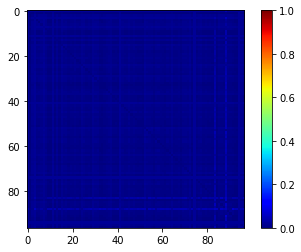

========class_1=======


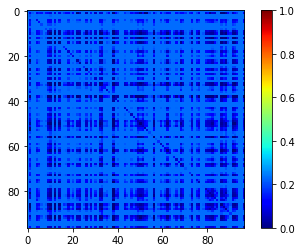

========class_2=======


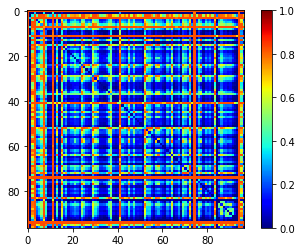

========class_3=======


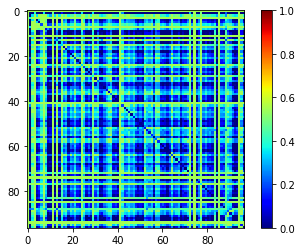

========whole=======


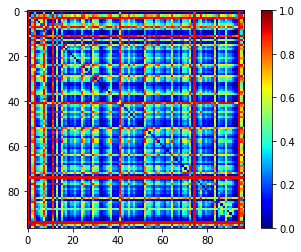

========ET=======


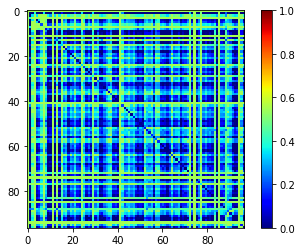

========CT=======


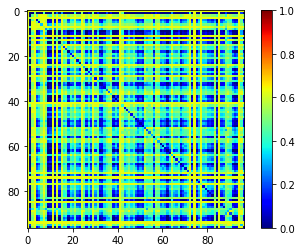

Huge cluster size, may not be significant, cluster size: 72, total data size: 56
Huge cluster size, may not be significant, cluster size: 43, total data size: 21
{'node_0': {'CT': 0.10126943683572279,
            'ET': -0.019935149212958164,
            'class_0': 0.0035371348281998173,
            'class_1': 0.17693424473491728,
            'class_2': 0.0936957552007207,
            'class_3': -0.019935149212958164,
            'whole': 0.11506781937408403},
 'node_1': {'CT': 0.45411730777816395,
            'ET': 0.37748903021025493,
            'class_0': 0.012801810789250611,
            'class_1': 0.18355741312956364,
            'class_2': 0.5704136586124524,
            'class_3': 0.37748903021025493,
            'whole': 0.5263356139161939},
 'node_10': {'CT': 0.050540914043582776,
             'ET': 0.016863107018742107,
             'class_0': 0.0007603323063028022,
             'class_1': 0.06210613124707094,
             'class_2': 0.03866503354566745,
             'class_3

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

save_root = './Logs/DiceGraphs/{}/'.format(seq)
with open(os.path.join(save_root, 'Graph_AMs.cpickle'), 'rb') as file:
    AM = pickle.load(file)

G = delta.DeltaGraph(model, weights_path, metric, classinfo = infoclasses)
for class_ in infoclasses.keys():
    print ("========{}=======".format(class_))
    plt.clf()
    plt.imshow(AM[class_], cmap ='jet', vmin = 0, vmax = 1)
    plt.colorbar()
    plt.show()
    plt.savefig(os.path.join(save_root, class_+'.png'), bbox_inches="tight")

significance = G.node_significance(concepts_info, dataset_path = data_root_path, loader = dataloader(), save_path = save_root)
pprint(significance)

In [ ]:
# modify concepts info